In [ ]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# Set the display option to show all columns
pd.set_option('display.max_columns', None)  # No column limit
# pd.set_option('display.max_rows', None)     # No row limit

import matplotlib as mpl
#mpl.use('pdf')
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
from pylab import cm
from matplotlib.cbook import boxplot_stats
from matplotlib.legend_handler import HandlerTuple
from matplotlib.colors import Normalize, to_rgba

from scipy.stats.mstats import hmean

from pprint import pprint
from IPython.display import display, HTML

import os
import subprocess
import re

import json

sns.set_palette("colorblind")  # or "deep", "pastel", etc.

width = 12
height = 6

# original for IEEE paper
# width = 3.487
# height = width/1.618

In [1]:
LLC_THRESHOLD = 128 # 128 MB of L3 cache of AMD-EPYC-24

In [2]:
# Input: a dataframe column (e.g., df['gflops'])
def boxplot_statistics(subset):
    if(subset.shape[0]==0):
        return 0.0, 0.0, 0.0, 0.0
    else:
        q1 = subset.quantile(0.25)
        q2 = subset.median()
        q3 = subset.quantile(0.75)
        max_val = subset.max()
        
        return round(q1), round(q2), round(q3), round(max_val)

# Input: "./plots/blabla.pdf"
# It produces the pdf plot at first, and then through pdftoppm the equivalent png plot.
# Then it moves the pdf in another directory
def save_plot(pdf_path, dpi=300, scale_x=2880):
    # Ensure directory exists
    os.makedirs(os.path.dirname(pdf_path), exist_ok=True)

    # PNG path
    png_path = pdf_path.replace(".pdf", ".png")

    # Save as PDF
    plt.savefig(pdf_path, dpi=dpi, bbox_inches="tight")

    # Convert PDF → PNG
    subprocess.run([
        "pdftoppm", pdf_path,
        "-png", "-scale-to-x", str(scale_x), "-scale-to-y", "-1",
        "-singlefile",
        png_path[:-4]  # pdftoppm expects basename without .png
    ], check=True)

    # Ensure ./plots/pdf_plots exists and move the PDF
    subprocess.run(["mkdir", "-p", "./plots/pdf_plots"], check=True)
    new_pdf_path = f"./plots/pdf_plots/{pdf_path.split('/')[-1]}"
    subprocess.run(["mv", pdf_path, new_pdf_path], check=True)
    
    # print(f"✅ Saved: {pdf_path}")
    # print(f"✅ Saved: {png_path}")
    print(f'>>> Plotted {pdf_path} successfully!')

---
SpMM:

I need to remove ACC (because it runs for mc2depi only) as well as HC (also runs for the same matrix only)

Perhaps for different that SuiteSparse matrices these will run successfully...

SDDMM:

Sputnik is not able to achieve >1 GF... So I removed it for SuiteSparse matrices, perhaps consider it for DLMC matrices...

RoDe also produced wrong results... So it is not considered for now, because it achieved unexplainable performance.


In [3]:
spmm_gpu_formats_mapping = {
    'CUSPARSE_CSR': 'cuSPARSE',
    'ASpT-GPU': 'ASpT-GPU',
    'RoDe': 'RoDe',
    'dgSPARSE-0': 'dgSPARSE-0',
    'dgSPARSE-1': 'dgSPARSE-1',
    'dgSPARSE-2': 'dgSPARSE-2',
    'dgSPARSE-3': 'dgSPARSE-3',
    'dgSPARSE-4': 'dgSPARSE-4',
    'dgSPARSE-5': 'dgSPARSE-5',
    'GNN-Pilot-1': 'GNN-Pilot-1',
    'GNN-Pilot-2': 'GNN-Pilot-2',
    'DTC-0': 'DTC-0',
    'DTC-1': 'DTC-1',
    'DTC-2': 'DTC-2',
    'DTC-3': 'DTC-3',
    'DTC-4': 'DTC-4',
    'DTC-5': 'DTC-5',
    'DTC-6': 'DTC-6',
    'Sputnik': 'Sputnik'
}

spmm_cpu_formats_mapping = {
    'MKL_IE': 'MKL',
    'AOCL':'AOCL',
    'ASpT-CPU':'ASpT-CPU',
    'FusedMM':'FusedMM'
}

sddmm_gpu_formats_mapping = {
    'CUSPARSE_CSR': 'cuSPARSE',
    'ASpT-GPU': 'ASpT-GPU',
    'dgSPARSE': 'dgSPARSE',
    'GNN-Pilot-1': 'GNN-Pilot'
}

sddmm_cpu_formats_mapping = {'ASpT-CPU': 'ASpT-CPU'}

#############

# spmm_gpu_formats = ['CUSPARSE_CSR','ACC','ASpT-GPU','RoDe','dgSPARSE-0','dgSPARSE-1','dgSPARSE-2','dgSPARSE-3','dgSPARSE-4','dgSPARSE-5','GNN-Pilot-1','GNN-Pilot-2','DTC-0','DTC-1','DTC-2','DTC-3','DTC-4','DTC-5','DTC-6','Sputnik']
spmm_gpu_formats = ['cuSPARSE','ASpT-GPU','RoDe','dgSPARSE-0','dgSPARSE-1','dgSPARSE-2','dgSPARSE-3','dgSPARSE-4','dgSPARSE-5','GNN-Pilot-1','GNN-Pilot-2','DTC-0','DTC-1','DTC-2','DTC-3','DTC-4','DTC-5','DTC-6','Sputnik']
spmm_cpu_formats = ['MKL','AOCL','ASpT-CPU','FusedMM']

# sddmm_gpu_formats = ['CUSPARSE_CSR', 'ASpT-GPU', 'RoDe', 'dgSPARSE', 'GNN-Pilot-1', 'Sputnik']
sddmm_gpu_formats = ['cuSPARSE', 'ASpT-GPU', 'dgSPARSE', 'GNN-Pilot']
sddmm_cpu_formats = ['ASpT-CPU']


---
# Preprocessing
## Log filtering

In [4]:
# Arithmetic intensity stuff here
# '''
# # Arithmetic intensity is calculated as floating point operations per byte
# # Total bytes moved are:
# # SpMM: sparse matrix (mem_footprint) + dense array X (n x k) + + dense array X (m x k) = mem_footprint + 2 * rows * k (in bytes)
# # SDDMM: 2 * nnz values (nnz from each dense array A and B) + nnz values for output = 3 * nnz
# # SDDMM: 2 * k * nnz values (from the dense arrays) + nnz values for output = (2*k + 1) * nnz (in bytes)

# # spmm_df['arithmetic_intensity']  = np.round((2 *  spmm_df['nnz'] *  spmm_df['k']) / (spmm_df['mem_footprint'] * (1024 ** 2)),4)
# spmm_df['ops'] = 2 *  spmm_df['nnz'] *  spmm_df['k']
# sddmm_df['ops'] = 2 *  sddmm_df['nnz'] * sddmm_df['k']

# spmm_df['bytes_theory'] = spmm_df['nnz'] * (4 + 4) + (spmm_df['rows']+1) * 4    +    spmm_df['rows'] * spmm_df['k'] * 4
# sddmm_df['bytes_theory'] = 2 * sddmm_df['nnz'] * sddmm_df['k'] * 4    +    sddmm_df['nnz'] * (4 + 4) + (sddmm_df['rows']+1) * 4

# # For now, it contains only GPU results. CPU will have to be added later...
# spmm_perf_bytes = pd.read_csv('./spmm_ncu_dram_bytes.csv')
# sddmm_perf_bytes = pd.read_csv('./sddmm_ncu_dram_bytes.csv')
# # After that, i also have to extend these dataframes for CPU results (perhaps from perf? don't know yet, it needs to be discussed)

# spmm_df = spmm_df.merge(spmm_perf_bytes[['matrix', 'format', 'k', 'bytes_perf']], on=['matrix', 'format', 'k'], how='left')
# sddmm_df = sddmm_df.merge(sddmm_perf_bytes[['matrix', 'format', 'k', 'bytes_perf']], on=['matrix', 'format', 'k'], how='left')

# spmm_df['Mbytes_total'] = np.round(spmm_df['bytes_perf']/(1024.0**2))
# sddmm_df['Mbytes_total'] = np.round(sddmm_df['bytes_perf']/(1024.0**2))

# # spmm_df['arithmetic_intensity']  = np.round(spmm_df['ops'] / spmm_df['bytes_theory'], 4)
# # sddmm_df['arithmetic_intensity'] = np.round(sddmm_df['ops'] / sddmm_df['bytes_theory'], 4)
# spmm_df['arithmetic_intensity']  = np.round(spmm_df['ops'] / spmm_df['bytes_perf'], 4)
# sddmm_df['arithmetic_intensity'] = np.round(sddmm_df['ops'] / sddmm_df['bytes_perf'], 4)

# columns_to_drop = ['ops', 'bytes_theory', 'bytes_perf']
# # columns_to_drop = ['ops', 'bytes_theory']
# spmm_df = spmm_df.drop(columns = columns_to_drop)
# sddmm_df = sddmm_df.drop(columns = columns_to_drop)
# '''



In [5]:
def fix_dataframe(df, gpu_formats, cpu_formats, kernel, matrix_type):
    # Remove the preprocessing columns
    columns_to_drop = ['read', 'coo_to_csr', 'convert_to_format']
    df = df.drop(columns = columns_to_drop)

    if(df.shape[0] != 0):
        # Group by matrix, format, and k
        df = df.groupby(['matrix', 'format', 'system', 'k'], as_index=False).mean(numeric_only=True)

        # Assuming float (32 bits) representation of the nonzeros
        df['mem_footprint'] = np.round((((4+4) * df['nnz'] + 4 * (df['rows'] + 1)) / (1024 ** 2)),4)
        df['sparsity'] = np.round((1 - (df['nnz'] * 1.0) / (df['rows'] * df['cols']))*100, 4)

        # arithmetic intensity stuff went there...

        df = df.sort_values(by='mem_footprint')

        # Split GPU and CPU results
        gpu_df = df[df['format'].isin(gpu_formats)].reset_index(drop=True)
        cpu_df = df[df['format'].isin(cpu_formats)].reset_index(drop=True)
        
        gpu_df['type'] = f'{kernel} GPU'
        cpu_df['type'] = f'{kernel} CPU'
        
        gpu_df['type_system'] = gpu_df['type'] + '\n' + gpu_df['system']
        cpu_df['type_system'] = cpu_df['type'] + '\n' + cpu_df['system']
    else:
        gpu_df = pd.DataFrame(columns=df.columns)
        cpu_df = pd.DataFrame(columns=df.columns)

    gpu_df['matrix_type'] = matrix_type
    cpu_df['matrix_type'] = matrix_type

    return gpu_df, cpu_df

# r"\((?P<rows>\d+) rows, (?P<nnz>\d+) nnz\), "
def extract_results(log_files, matrix_prefix, plot_prefix):
    # Define patterns
    pattern = re.compile(
        r"(SpMM|SDDMM) kernel - matrix: (?P<matrix>\S+) "
        r"\((?P<rows>\d+) rows, (?P<cols>\d+) cols, (?P<nnz>\d+) nnz\), "
        r"read: (?P<read>[\d.]+), "
        r"coo_to_csr: (?P<coo_to_csr>[\d.]+), "
        r"format_conversion: (?P<convert_to_format>[\d.]+), "
        r"format: (?P<format>[\w\-]+), "
        r"k: (?P<k>\d+), "
        r"system: (?P<system>[\w\-]+), "
        r"gflops: (?P<gflops>[\d.]+)"
    )

    # Store results
    spmm_data = []
    sddmm_data = []

    for log_path in log_files:
        with open(log_path, "r") as f:
            for line in f:
                match = pattern.search(line)
                if match:
                    entry = match.groupdict()
                    # Convert numeric fields
                    # entry["matrix"] = os.path.splitext(os.path.basename(entry["matrix"]))[0]
                    entry["matrix"] = os.path.splitext(entry["matrix"].removeprefix(matrix_prefix))[0]

                    entry["rows"] = int(entry["rows"])
                    entry["cols"] = int(entry["cols"])
                    entry["nnz"] = int(entry["nnz"])
                    entry["read"] = float(entry["read"])
                    entry["coo_to_csr"] = float(entry["coo_to_csr"])
                    entry["convert_to_format"] = float(entry["convert_to_format"])
                    entry["k"] = int(entry["k"])
                    entry["gflops"] = float(entry["gflops"])
    
                    if match.group(1) == "SpMM":
                        spmm_data.append(entry)
                    else:
                        sddmm_data.append(entry)

    # Convert to DataFrames
    spmm_df = pd.DataFrame(spmm_data)
    sddmm_df = pd.DataFrame(sddmm_data)

    # if DLMC, need to filter out the matrices with 33288 rows (because they lead to misleading results)
    if(plot_prefix == 'DLMC'):
        spmm_df = spmm_df[spmm_df['rows'] != 33288]
        
    # if(sddmm_df.shape[0]==0):
    #     sddmm_df = pd.DataFrame(columns=spmm_df.columns)

    spmm_df['format'] = spmm_df['format'].replace(spmm_gpu_formats_mapping | spmm_cpu_formats_mapping)
    sddmm_df['format'] = sddmm_df['format'].replace(sddmm_gpu_formats_mapping | sddmm_cpu_formats_mapping)

    # Extend the dataframes with new columns and remove unnecessary ones...
    spmm_gpu_df, spmm_cpu_df   = fix_dataframe(spmm_df, spmm_gpu_formats, spmm_cpu_formats, 'SpMM', plot_prefix)
    sddmm_gpu_df, sddmm_cpu_df = fix_dataframe(sddmm_df, sddmm_gpu_formats, sddmm_cpu_formats, 'SDDMM', plot_prefix)

    max_spmm_gpu = spmm_gpu_df['gflops'].max()
    max_sddmm_gpu = sddmm_gpu_df['gflops'].max()
    max_spmm_cpu = spmm_cpu_df['gflops'].max()
    max_sddmm_cpu = sddmm_cpu_df['gflops'].max()
    max_gflops_values = {
        'SpMM GPU': max_spmm_gpu,
        'SDDMM GPU': max_sddmm_gpu,
        'SpMM CPU': max_spmm_cpu,
        'SDDMM CPU': max_sddmm_cpu,
    }
    
    combined_df = pd.concat([spmm_gpu_df, sddmm_gpu_df, spmm_cpu_df, sddmm_cpu_df])
    # Exit filtering function and return the 4 dataframes
    return spmm_gpu_df, spmm_cpu_df, sddmm_gpu_df, sddmm_cpu_df, combined_df, max_gflops_values


In [6]:
%%time 

# log_files = ['./log_file_k16.txt', './log_file_k32.txt', './log_file_k64.txt', './log_file_k128.txt', './log_file_k256.txt', './log_file_k512.txt', './log_file_k1024.txt',
#             './log_file_laptop.txt']

log_files = ['./log_file_sparse_survey.txt', './log_file_sparse_survey2.txt', './log_file_sparse_survey3.txt',
             './log_file_sparse_survey4.txt', './log_file_sparse_survey5.txt']
matrix_prefix_gr = './matrices/'
plot_prefix_gr = 'Graph'

spmm_gpu_df_gr, spmm_cpu_df_gr, sddmm_gpu_df_gr, sddmm_cpu_df_gr, combined_df_gr, max_gflops_values_gr = extract_results(log_files, matrix_prefix_gr, plot_prefix_gr)


log_files = ['log_file_sparse_survey_dlmc.txt', 'log_file_sparse_survey_dlmc2.txt', 'log_file_sparse_survey_dlmc3.txt',
             'log_file_sparse_survey_dlmc4.txt', 'log_file_sparse_survey_dlmc5.txt']
matrix_prefix_dl = '/various/itasou/dlmc/transformer/'
plot_prefix_dl = 'DLMC'

spmm_gpu_df_dl, spmm_cpu_df_dl, sddmm_gpu_df_dl, sddmm_cpu_df_dl, combined_df_dl, max_gflops_values_dl = extract_results(log_files, matrix_prefix_dl, plot_prefix_dl)


CPU times: user 19.5 s, sys: 2.72 s, total: 22.3 s
Wall time: 22.6 s


---
## Also extend the memory footprint, to include the dense arrays that participate in the computations.

In [7]:
def extend_df_footprint(df, kernel, verbose=False):
    if(df.shape[0]!=0):
        # SpMM: sparse matrix + dense input matrix + dense output matrix (suppose that rows=cols for sparse matrix)
        if(kernel=='SpMM'):
            df['mem_footprint_total'] = np.round(df['mem_footprint'] + (2 * df['rows'] * df['k'] * 4) / (1024.0**2))
        # SDDMM: sparse matrix input (row_ptr+col_idx) + sparse matrix output (values) + k elements from each dense input matrix for each nonzero of sparse matrix
        if(kernel=='SDDMM'):
            df['mem_footprint_total'] = np.round(df['mem_footprint'] + (2 * df['k'] * df['nnz']  * 4) / (1024.0**2))
    
    if any('CPU' in t for t in df['type'].unique()):
        df['LLC_split'] = np.where(df['mem_footprint_total'] > LLC_THRESHOLD, '>LLC', '<LLC')
    else:
        df['LLC_split'] = 'NULL'
    return df
    
def extend_df_footprints(spmm_gpu_df, spmm_cpu_df, sddmm_gpu_df, sddmm_cpu_df):
    spmm_gpu_df = extend_df_footprint(spmm_gpu_df, 'SpMM')
    spmm_cpu_df = extend_df_footprint(spmm_cpu_df, 'SpMM')
    
    sddmm_gpu_df = extend_df_footprint(sddmm_gpu_df, 'SDDMM')
    sddmm_cpu_df = extend_df_footprint(sddmm_cpu_df, 'SDDMM')
    return spmm_gpu_df, spmm_cpu_df, sddmm_gpu_df, sddmm_cpu_df

spmm_gpu_df_gr, spmm_cpu_df_gr, sddmm_gpu_df_gr, sddmm_cpu_df_gr = extend_df_footprints(spmm_gpu_df_gr, spmm_cpu_df_gr, sddmm_gpu_df_gr, sddmm_cpu_df_gr)
spmm_gpu_df_dl, spmm_cpu_df_dl, sddmm_gpu_df_dl, sddmm_cpu_df_dl = extend_df_footprints(spmm_gpu_df_dl, spmm_cpu_df_dl, sddmm_gpu_df_dl, sddmm_cpu_df_dl)


## For DLMC matrices, add a new column which will be the category they belong to (for SpMM:, for SDDMM:)


In [8]:
spmm_gpu_df_dl['DLMC_type'] = spmm_gpu_df_dl['matrix'].str.split('/').str[0]
spmm_cpu_df_dl['DLMC_type'] = spmm_cpu_df_dl['matrix'].str.split('/').str[0]
sddmm_gpu_df_dl['DLMC_type'] = sddmm_gpu_df_dl["matrix"].str.split("_").str[:2].str.join("_")
sddmm_cpu_df_dl ['DLMC_type'] = sddmm_cpu_df_dl["matrix"].str.split("_").str[:2].str.join("_")

---
## Combine dataframes of both matrix datasets into one (we will distinguish them through 'matrix_type' later on...)

In [9]:
spmm_gpu_df = pd.concat([spmm_gpu_df_gr, spmm_gpu_df_dl])
spmm_cpu_df = pd.concat([spmm_cpu_df_gr, spmm_cpu_df_dl])
sddmm_gpu_df = pd.concat([sddmm_gpu_df_gr, sddmm_gpu_df_dl])
sddmm_cpu_df = pd.concat([sddmm_cpu_df_gr, sddmm_cpu_df_dl])
combined_df = pd.concat([combined_df_gr, combined_df_dl])

devices = ['GPU', 'CPU']
kernels = ['SpMM', 'SDDMM']

spmm_formats = {'GPU': spmm_gpu_formats, 'CPU': spmm_cpu_formats}
sddmm_formats = {'GPU': sddmm_gpu_formats, 'CPU': sddmm_cpu_formats}

spmm_dfs = {'GPU': spmm_gpu_df, 'CPU': spmm_cpu_df}
sddmm_dfs = {'GPU': sddmm_gpu_df, 'CPU': sddmm_cpu_df}
dfs = {'SpMM': spmm_dfs, 'SDDMM': sddmm_dfs}
formats = {'SpMM': spmm_formats, 'SDDMM': sddmm_formats}


---
# First, print some information about the datasets that are examined


In [42]:
def plot_frequency_histogram(values, bins=20, title="Frequency Histogram"):
    plt.figure(figsize=(6, 4))
    plt.hist(values, bins=bins, edgecolor="black")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

def extract_matrix_dataset(df):
    # The columns that define a matrix uniquely
    matrix_props = ['matrix', 'rows', 'nnz', 'sparsity', 'mem_footprint']
    
    # Extract unique matrices
    matrix_dataset = df[matrix_props].drop_duplicates().reset_index(drop=True)

    # Cast to integer where appropriate
    matrix_dataset = matrix_dataset.astype({'rows': 'int64', 'nnz': 'int64'})
    # matrix_dataset['avg_nnz_per_row'] = np.round(matrix_dataset['nnz'] / matrix_dataset['rows'], 2)
    matrix_dataset['mem_footprint'] = np.round(matrix_dataset['mem_footprint'],2)
    matrix_dataset['sparsity'] = np.round(matrix_dataset['sparsity'],4)

    return matrix_dataset


In [43]:
matrix_dataset_gr = extract_matrix_dataset(spmm_gpu_df_gr)
display(matrix_dataset_gr)
# print(sorted(set(matrix_dataset_gr['rows'])))
# print(sorted(set(matrix_dataset_gr['cols'])))
# print(sorted(set(matrix_dataset_gr['nnz'].round(-2))))


,matrix,rows,nnz,sparsity,mem_footprint
0,citeseer,3327,9340,99.9156,0.08
1,cora,2708,10858,99.8519,0.09
2,pubmed,19717,88673,99.9772,0.75
3,PROTEINS,43471,162088,99.9914,1.40
4,ogbl-ddi,4267,1067911,94.1347,8.16
5,ogbl-collab,235868,967632,99.9983,8.28
6,ogbn-arxiv,169343,1166243,99.9959,9.54
7,harvard,15126,1649234,99.2792,12.64
8,com-Amazon,334863,1851744,99.9983,15.41
9,REDDIT-BINARY,859254,1991016,99.9997,18.47


,matrix,rows,cols,nnz,mem_footprint,sparsity,avg_nnz_per_row
0,variational_dropout/0.98/body_decoder_layer_0_...,512,512,246,0.0038,99.9062,0.48
1,variational_dropout/0.98/body_encoder_layer_2_...,512,2048,274,0.0040,99.9739,0.54
2,variational_dropout/0.98/body_encoder_layer_1_...,512,512,301,0.0043,99.8852,0.59
3,l0_regularization/0.98/body_encoder_layer_5_se...,512,512,391,0.0049,99.8508,0.76
4,variational_dropout/0.98/body_decoder_layer_3_...,512,512,401,0.0050,99.8470,0.78
...,...,...,...,...,...,...,...
2646,l0_regularization/0.5/body_decoder_layer_3_ffn...,2048,512,640824,4.8969,38.8863,312.90
2647,l0_regularization/0.5/body_decoder_layer_4_ffn...,2048,512,655737,5.0107,37.4640,320.18
2648,l0_regularization/0.5/body_decoder_layer_0_ffn...,2048,512,657561,5.0246,37.2901,321.07
2649,variational_dropout/0.5/body_decoder_layer_5_f...,2048,512,662743,5.0641,36.7959,323.60


[512, 2048]
[512, 2048]


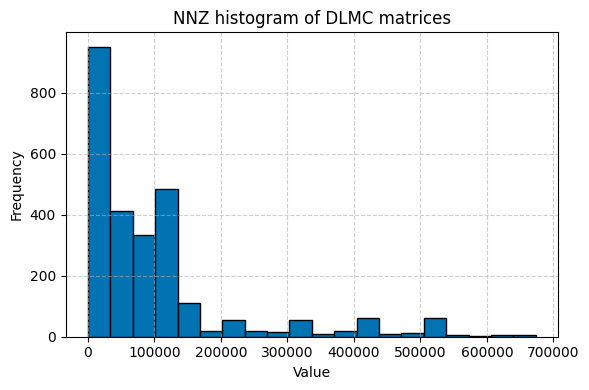

[32.0, 33.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0]


In [12]:
matrix_dataset_dl = extract_matrix_dataset(spmm_gpu_df_dl)
display(matrix_dataset_dl)
print(sorted(set(matrix_dataset_dl['rows'])))
print(sorted(set(matrix_dataset_dl['cols'])))
# print(sorted(set(matrix_dataset_dl['nnz'].round(-2))))
plot_frequency_histogram(matrix_dataset_dl['nnz'], title='NNZ histogram of DLMC matrices')
print(sorted(set(matrix_dataset_dl['sparsity'].round())))


---
#  

---
# Kernel performance
## (left: GPU, right: CPU) / (left: Graph, right: DLMC)

In [13]:
bp_w = 0.45 # boxplot width
bp_lw = 0.75 # boxplot linewidth (outline)

def plot_kernel_performance(kernel, gpu_df, cpu_df, k_filter=[], per_k = False, store_it=False, 
                            LLC_split_flag=False, LLC_overlay_boxplot=False):
    df = pd.concat([gpu_df, cpu_df])

    if((len(k_filter)==0) or (len(k_filter)>1)):
        per_k = True
        print(f'More than 1 "k" values will be presented (k_filter={k_filter}), switching to "per_k" mode!')

    if k_filter:
        df_filtered = df[df['k'].isin(k_filter)]
    else:
        df_filtered = df
    
    fig, axes = plt.subplots(1, 2, figsize=(width, height))
    subsets = {
        'GPU': df_filtered[df_filtered['type'].str.contains('GPU')],
        'CPU': df_filtered[df_filtered['type'].str.contains('CPU')]
    }

    for idx, (label, df_plot) in enumerate(subsets.items()):
        ax = axes[idx]

        if per_k:
            sns.boxplot(data=df_plot, x='matrix_type', y='gflops', width=bp_w, linewidth=bp_lw, ax=ax, 
                        hue='k', flierprops=dict(marker='.', markersize=3))
        else:
            if(LLC_split_flag and idx==1):
                if(LLC_overlay_boxplot):
                    # background (shaded, no hue)
                    sns.boxplot(
                        data=df_plot, x='matrix_type', y='gflops',
                        width=bp_w, ax=ax, 
                        linewidth=bp_lw,
                        # color='lightgray', 
                        palette=['tab:blue'],
                        flierprops=dict(marker='', markersize=0),  # hide fliers here
                        boxprops=dict(alpha=0.15),                  # transparent
                        whiskerprops=dict(alpha=0.15),
                        capprops=dict(alpha=0.15),
                        medianprops=dict(alpha=0.15, color='black')
                    )
                    
                    # foreground (colored by LLC_split)
                    sns.boxplot(
                        data=df_plot, x='matrix_type', y='gflops',
                        width=0.75*bp_w, linewidth=bp_lw, ax=ax,
                        hue='LLC_split', palette=['tab:green', 'tab:red'],
                        flierprops=dict(marker='.', markersize=3)
                    )
                    ax.legend(title='LLC split')

                else:
                    sns.boxplot(data=df_plot, x='matrix_type', y='gflops', 
                                width=bp_w, linewidth=bp_lw, ax=ax, 
                                hue='LLC_split', palette=['tab:green', 'tab:red'],
                                flierprops=dict(marker='.', markersize=3))
            else:
                sns.boxplot(data=df_plot, x='matrix_type', y='gflops', width=bp_w, linewidth=bp_lw, ax=ax, 
                            palette=['tab:blue'],
                            flierprops=dict(marker='.', markersize=3))
                # plt.legend([], [], frameon=False)

        # Print statistics only if one k_filter is used (would be cluttered otherwise)
        if(len(k_filter)==1):
            for i, ts in enumerate(df_plot['type_system'].unique()):
                subset0 = df_plot[df_plot['type_system'] == ts]
                for j, tj in enumerate(subset0['matrix_type'].unique()):
                    subset = subset0[subset0['matrix_type'] == tj]
                    q1, q2, q3, max_val = boxplot_statistics(subset['gflops'])
                    print(tj, '\t', ts.replace("\n", " "), f'\t 25%: {q1} GF, median: {q2} GF, 75%: {q3} GF, max: {max_val} GF')
                    if('CPU' in ts): # Also print statistics for the two different, based on LLC size, measurements
                        subset_small = subset[subset['LLC_split'] == '<LLC']
                        dataset_size = len(subset_small['matrix'].unique())
                        q1, q2, q3, max_val = boxplot_statistics(subset_small['gflops'])
                        print(f'\t\t\t  (<LLC) 25%: {q1} GF, median: {q2} GF, 75%: {q3} GF, max: {max_val} GF ({dataset_size} matrices)')

                        subset_large = subset[subset['LLC_split'] == '>LLC']
                        dataset_size = len(subset_large['matrix'].unique())
                        q1, q2, q3, max_val = boxplot_statistics(subset_large['gflops'])
                        print(f'\t\t\t  (>LLC) 25%: {q1} GF, median: {q2} GF, 75%: {q3} GF, max: {max_val} GF ({dataset_size} matrices)')

        # Get tick positions and their text directly
        ticks = ax.get_xticks()
        labels = [lab.get_text() for lab in ax.get_xticklabels()]
        
        # Replace with only the first word
        ax.set_xticks(ticks)  # keep positions unchanged
        ax.set_xticklabels([lab.split()[0] for lab in labels])
        
        ax.set_title(f'{label} Performance')
        # ax.set_xlabel('System')
        ax.set_xlabel('')
        ax.set_ylabel('Performance (GFLOPs/s)')
        ax.tick_params(axis='x', rotation=0)

    plt.tight_layout()
    if store_it:
        save_path = f'./plots/{kernel}_performance_plot__k_{k_filter}.pdf'
        if per_k:
            save_path = save_path.replace('.pdf', '_per_k.pdf')
        if LLC_split_flag:
            save_path = save_path.replace('.pdf', '_LLC_split.pdf')
        save_plot(save_path)
    else:    
        plt.show()
    plt.close()

per_k=False
store_it=True
# LLC_split_flag=False
LLC_split_flag=True
# LLC_overlay_boxplot=False
LLC_overlay_boxplot=True

# k_filter = [32, 128, 1024]
k_filter = [128]
# k_filter = []

for kernel in kernels:
    print(f'{kernel} kernel')
    plot_kernel_performance(kernel, dfs[kernel]['GPU'], dfs[kernel]['CPU'], k_filter=k_filter, per_k=per_k, store_it=store_it, LLC_split_flag=LLC_split_flag, LLC_overlay_boxplot=LLC_overlay_boxplot)
    print()


SpMM kernel
Graph 	 SpMM GPU NVIDIA-A100 	 25%: 207 GF, median: 485 GF, 75%: 755 GF, max: 2657 GF
DLMC 	 SpMM GPU NVIDIA-A100 	 25%: 149 GF, median: 335 GF, 75%: 624 GF, max: 3184 GF
Graph 	 SpMM CPU AMD-EPYC-24 	 25%: 26 GF, median: 39 GF, 75%: 160 GF, max: 640 GF
			  (<LLC) 25%: 121 GF, median: 186 GF, 75%: 291 GF, max: 640 GF (6 matrices)
			  (>LLC) 25%: 22 GF, median: 29 GF, 75%: 38 GF, max: 333 GF (12 matrices)
DLMC 	 SpMM CPU AMD-EPYC-24 	 25%: 124 GF, median: 262 GF, 75%: 361 GF, max: 548 GF
			  (<LLC) 25%: 124 GF, median: 262 GF, 75%: 361 GF, max: 548 GF (2652 matrices)
			  (>LLC) 25%: 0.0 GF, median: 0.0 GF, 75%: 0.0 GF, max: 0.0 GF (0 matrices)
>>> Plotted ./plots/SpMM_performance_plot__k_[128]_LLC_split.pdf successfully!

SDDMM kernel
Graph 	 SDDMM GPU NVIDIA-A100 	 25%: 118 GF, median: 217 GF, 75%: 328 GF, max: 944 GF
DLMC 	 SDDMM GPU NVIDIA-A100 	 25%: 289 GF, median: 405 GF, 75%: 746 GF, max: 4312 GF
Graph 	 SDDMM CPU AMD-EPYC-24 	 25%: 27 GF, median: 32 GF, 75%: 52 G

---
# Comparison of formats
## Combine the two datasets in one plot

In [14]:
bp_w = 0.4 # boxplot width
bp_lw = 0.75 # boxplot linewidth (outline)

def plot_format_performance(kernel, device, df, formats, k_filter, hue_parameter, store_it=False, extra='', ylim_top=0, matrix_type='Graph'):
    df_filtered = df[df['k'].isin(k_filter)]

    if hue_parameter=='k':
        df_filtered = df_filtered[df_filtered['matrix_type']==matrix_type]
    
    plt.figure(figsize=(width, height))
    sns.boxplot(data=df_filtered, x='format', y='gflops', hue=hue_parameter, order=formats, width=bp_w, flierprops=dict(marker='.', markersize=3))
    plt.title(f'{kernel} performance on {device} for different formats')

    if(hue_parameter=='matrix_type'):
        plt.legend(title = 'Matrix dataset')
    if(ylim_top != 0):
        plt.ylim(bottom=0, top=1.05*ylim_top)
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Performance (GFLOPs/s)')
    plt.tick_params(axis='x', rotation=0)

    plt.tight_layout()
    if store_it:
        save_path = f'./plots/{kernel}_{device}_format_performance__k_{k_filter}{extra}.pdf'
        if(hue_parameter=='k'):
            save_path = save_path.replace('.pdf', f'_{matrix_type}.pdf')
        save_plot(save_path)
    else:    
        plt.show()
    plt.close()

store_it = True
# k_filter = [32, 128, 1024]
k_filter = [128]

hue_parameter='matrix_type'

for kernel in kernels:
    for device in devices:
        plot_format_performance(kernel, device, dfs[kernel][device], formats[kernel][device], k_filter, hue_parameter='matrix_type', store_it=True)


>>> Plotted ./plots/SpMM_GPU_format_performance__k_[128].pdf successfully!
>>> Plotted ./plots/SpMM_CPU_format_performance__k_[128].pdf successfully!
>>> Plotted ./plots/SDDMM_GPU_format_performance__k_[128].pdf successfully!
>>> Plotted ./plots/SDDMM_CPU_format_performance__k_[128].pdf successfully!


## Version 2 of this plot, GPU and CPU together in one plot (instead of two separate)

In [15]:
bp_w = 0.4 # boxplot width
bp_lw = 0.75 # boxplot linewidth (outline)

def plot_format_performance2(kernel, gpu_df, cpu_df, gpu_formats, cpu_formats, k_filter, hue_parameter, store_it=False, extra='', ylim_top=0, matrix_type='Graph'):
    df = pd.concat([gpu_df, cpu_df])

    if k_filter:
        df_filtered = df[df['k'].isin(k_filter)]
    else:
        df_filtered = df
    
    if hue_parameter=='k':
        df_filtered = df_filtered[df_filtered['matrix_type']==matrix_type]

    fig, axes = plt.subplots(1, 2, figsize=(width, height),
                             gridspec_kw={"width_ratios": [len(gpu_formats), len(cpu_formats)]}  # first subplot 7/11, second 4/11)
                            )
    subsets = {
        'GPU': df_filtered[df_filtered['type'].str.contains('GPU')],
        'CPU': df_filtered[df_filtered['type'].str.contains('CPU')]
    }
   
    for idx, (label, df_plot) in enumerate(subsets.items()):
        ax = axes[idx]

        if(idx==0):
            sns.boxplot(data=df_plot, x='format', y='gflops', hue=hue_parameter, ax=ax, order=gpu_formats, width=bp_w, flierprops=dict(marker='.', markersize=3))
        else:
            sns.boxplot(data=df_plot, x='format', y='gflops', hue=hue_parameter, ax=ax, order=cpu_formats, width=bp_w, flierprops=dict(marker='.', markersize=3))
        plt.title(f'{kernel} performance on {device} for different formats')

        if(hue_parameter=='matrix_type'):
            ax.legend(title = 'Matrix dataset')
        if(ylim_top != 0):
            ax.ylim(bottom=0, top=1.05*ylim_top)
        if(idx==0):
            ax.legend([], [], frameon=False)
        else:
            ax.legend(loc='upper right')
    
        # Get tick positions and their text directly
        ticks = ax.get_xticks()
        labels = [lab.get_text() for lab in ax.get_xticklabels()]
        
        # Replace with only the first word
        ax.set_xticks(ticks)  # keep positions unchanged
        ax.set_xticklabels([lab.split()[0] for lab in labels])
        
        ax.set_title(f'{label} Performance')
        # ax.set_xlabel('System')
        ax.set_xlabel('')
        ax.set_ylabel('Performance (GFLOPs/s)')
        ax.tick_params(axis='x', rotation=0)

    plt.tight_layout()
    if store_it:
        save_path = f'./plots/{kernel}_format_performance__k_{k_filter}{extra}.pdf'
        if(hue_parameter=='k'):
            save_path = save_path.replace('.pdf', f'_{matrix_type}.pdf')
        save_plot(save_path)
    else:    
        plt.show()
    plt.close()

store_it = True
# k_filter = [32, 128, 1024]
k_filter = [128]

hue_parameter='matrix_type'

for kernel in kernels:
    plot_format_performance2(kernel, dfs[kernel]['GPU'], dfs[kernel]['CPU'], formats[kernel]['GPU'], formats[kernel]['CPU'], k_filter, hue_parameter='matrix_type', store_it=True)


>>> Plotted ./plots/SpMM_format_performance__k_[128].pdf successfully!
>>> Plotted ./plots/SDDMM_format_performance__k_[128].pdf successfully!


---
## For SpMM - GPU, there are three formats that appear in multiple versions. Need to select the best of each and filter the others out. The produced dataframes will show which version to keep out of each format family.


In [16]:
def pivot_dataframe(df):
    # Step 1: Create a unique column for pivoting
    df['format_k'] = df['format'] + '_' + df['k'].astype(str)
    
    # Step 2: List the value columns you'd like to pivot
    # value_cols = ['gflops', 'Mbytes_total', 'arithmetic_intensity']
    value_cols = ['gflops']
    
    # Step 3: Pivot the table for each metric and join them
    pivoted_dfs = []
    for col in value_cols:
        pivot = df.pivot(index='matrix', columns='format_k', values=col)
        pivot.columns = [f"{col}_{c}" for c in pivot.columns]  # Flatten column names
        pivoted_dfs.append(pivot)
    
    # Step 4: Concatenate all pivoted metrics
    wide_metrics_df = pd.concat(pivoted_dfs, axis=1).reset_index()
    
    # Step 5: Extract shared columns (like rows, nnz, sparsity) from one row per matrix
    # (assuming they are consistent per matrix)
    static_cols = ['matrix', 'rows', 'nnz', 'sparsity', 'mem_footprint']
    static_info = df[static_cols].drop_duplicates(subset='matrix')
    
    # Step 6: Merge back to final DataFrame
    final_df = static_info.merge(wide_metrics_df, on='matrix')
    return final_df

def format_version_extract_best(df, pivot_df, k):
    matrices = pivot_df['matrix']
    
    # Filter for this k value
    df_filtered = df[df['k'] == k]
    
    repeating_formats = ['dgSPARSE', 'GNN-Pilot', 'DTC']
    
    # You know the version names in advance
    dgsparse_versions = [f'dgSPARSE-{i}' for i in range(6)]
    gnn_pilot_versions = [f'GNN-Pilot-{i}' for i in range(1,3)]
    dtc_versions = [f'DTC-{i}' for i in range(7)]
    
    dgsparse_dict = {v: 0 for v in dgsparse_versions}
    gnn_pilot_dict = {v: 0 for v in gnn_pilot_versions}
    dtc_dict = {v: 0 for v in dtc_versions}
    
    rf_dict = {
        'dgSPARSE': dgsparse_dict,
        'GNN-Pilot': gnn_pilot_dict,
        'DTC': dtc_dict 
    }
    
    # Initialize dictionary to hold counts for each base format
    format_counts = {}
    
    for repeating_format in repeating_formats:
        df1 = df_filtered[df_filtered['format'].str.contains(repeating_format)]
        for matrix in matrices:
            df2 = df1[df1['matrix']==matrix]
            if(df2.shape[0]==0):
                best_format = None
            else:
                best_format = df_filtered.loc[df2['gflops'].idxmax(), 'format']
                # print(best_format)
                rf_dict[repeating_format][best_format] += 1
    return rf_dict

spmm_gpu_pivot_df_gr = pivot_dataframe(spmm_gpu_df_gr)
spmm_gpu_pivot_df_dl = pivot_dataframe(spmm_gpu_df_dl)


In [18]:
def rf_dict_wrapper(df, pivot_df):
    rf_dict = {}
    for i in range(4, 11):
        k = 2 ** i
        rf_dict[k] = format_version_extract_best(df, pivot_df, k)
    
    combined_rf_df = pd.DataFrame()
    for k_val, nested_dict in rf_dict.items():
        flat_dict = {}
        for group in nested_dict.values():
            flat_dict.update(group)
        combined_rf_df[k_val] = pd.Series(flat_dict)
    return combined_rf_df

combined_rf_df_gr = rf_dict_wrapper(spmm_gpu_df_gr, spmm_gpu_pivot_df_gr)
print('Graph matrices')
display(combined_rf_df_gr)

combined_rf_df_dl = rf_dict_wrapper(spmm_gpu_df_dl, spmm_gpu_pivot_df_dl)
print('DLMC matrices')
display(combined_rf_df_dl)


Graph matrices


,16,32,64,128,256,512,1024
dgSPARSE-0,3,5,8,2,1,1,0
dgSPARSE-1,2,1,0,0,0,0,0
dgSPARSE-2,4,4,0,0,0,0,0
dgSPARSE-3,0,0,1,0,0,0,0
dgSPARSE-4,3,0,4,3,4,2,2
dgSPARSE-5,6,8,5,13,13,15,14
GNN-Pilot-1,3,2,4,5,6,5,5
GNN-Pilot-2,15,16,14,13,12,13,11
DTC-0,1,1,0,0,0,0,0
DTC-1,7,1,0,0,0,1,0


DLMC matrices


,16,32,64,128,256,512,1024
dgSPARSE-0,12,174,74,786,765,1322,977
dgSPARSE-1,1087,1002,324,230,11,0,0
dgSPARSE-2,7,15,3,0,0,0,0
dgSPARSE-3,0,0,20,42,3,1,0
dgSPARSE-4,1527,1292,2214,1539,1697,1216,1498
dgSPARSE-5,18,168,16,54,175,112,176
GNN-Pilot-1,2296,2306,1273,40,3,12,33
GNN-Pilot-2,355,345,1378,2611,2648,2639,2618
DTC-0,643,686,500,140,5,0,0
DTC-1,1677,1569,496,166,5,0,0


---
## Therefore keep: dgSPARSE: 4, GNN-Pilot: 2, DTC: 2 for SpMM-GPU. And then replot the per-format comparison for SpMM-GPU

In [20]:
# You want to remove all "dgSPARSE", "DTC", "GNN-Pilot" rows, except one for each:
filter_dict = {
    "dgSPARSE": "dgSPARSE-4",
    "GNN-Pilot": "GNN-Pilot-2",
    "DTC": "DTC-2"
}

def filter_repeating_formats_out(df, column, filters):
    """
    Remove rows from the DataFrame where `column` contains any of the specified substrings,
    except when the value matches the exception given in the `filters` dict.

    Parameters:
    - df: pd.DataFrame
    - column: str — the name of the column to inspect
    - filters: dict — {substring_to_filter: exception_to_keep}

    Returns:
    - pd.DataFrame — filtered DataFrame
    """
    mask = pd.Series([True] * len(df), index=df.index)

    for substring, exception in filters.items():
        # rows that match the substring
        contains_substring = df[column].str.contains(substring, case=False, na=False)
        # except for the exception
        is_exception = df[column] == exception
        mask &= ~(contains_substring & ~is_exception)

    return df[mask]

def filter_format_list(format_list, filter_dict):
    result = []
    for fmt in format_list:
        for key, keep in filter_dict.items():
            if key in fmt:
                if fmt == keep:
                    result.append(fmt)
                break  # prevent matching multiple keys
        else:
            result.append(fmt)  # keep formats that are not in any key
    return result

# spmm_gpu_filtered_df = filter_repeating_formats_out(spmm_gpu_df, 'format', filter_dict)
spmm_gpu_filtered_df_gr = filter_repeating_formats_out(spmm_gpu_df_gr, 'format', filter_dict)
spmm_gpu_filtered_df_dl = filter_repeating_formats_out(spmm_gpu_df_dl, 'format', filter_dict)

# display(spmm_gpu_df_filtered)
spmm_gpu_filtered_formats = filter_format_list(spmm_gpu_formats, filter_dict)


## Store the old plot (renamed) and create the new plot for the SpMM-GPU!

In [21]:
kernel = 'SpMM'
device = 'GPU'
k_filter = [128]

# keep a backup just in case...
spmm_gpu_df_gr_old = spmm_gpu_df_gr
spmm_gpu_df_dl_old = spmm_gpu_df_dl
spmm_gpu_df_old = spmm_gpu_df
spmm_gpu_formats_old = spmm_gpu_formats

spmm_gpu_df_gr = spmm_gpu_filtered_df_gr
spmm_gpu_df_dl = spmm_gpu_filtered_df_dl
spmm_gpu_df = pd.concat([spmm_gpu_df_gr, spmm_gpu_df_dl])
spmm_gpu_formats = spmm_gpu_filtered_formats

# And update the existing collective dataframes with the necessary changes
spmm_dfs = {'GPU': spmm_gpu_df, 'CPU': spmm_cpu_df}
dfs = {'SpMM': spmm_dfs, 'SDDMM': sddmm_dfs}
spmm_formats = {'GPU': spmm_gpu_formats, 'CPU': spmm_cpu_formats}
formats = {'SpMM': spmm_formats, 'SDDMM': sddmm_formats}

# And replot the per-format comparison for the GPU (after renaming the old plot)
os.rename(f'./plots/{kernel}_{device}_format_performance__k_{k_filter}.png',
          f'./plots/{kernel}_{device}_format_performance__k_{k_filter}_old.png')
os.rename(f'./plots/pdf_plots/{kernel}_{device}_format_performance__k_{k_filter}.pdf',
          f'./plots/pdf_plots/{kernel}_{device}_format_performance__k_{k_filter}_old.pdf')
plot_format_performance(kernel, device, spmm_gpu_df, spmm_gpu_formats, k_filter, hue_parameter='matrix_type', store_it=True)

# IF VERSION 2 (GPU and CPU together)
os.rename(f'./plots/{kernel}_format_performance__k_{k_filter}.png',
          f'./plots/{kernel}_format_performance__k_{k_filter}_old.png')
os.rename(f'./plots/pdf_plots/{kernel}_format_performance__k_{k_filter}.pdf',
          f'./plots/pdf_plots/{kernel}_format_performance__k_{k_filter}_old.pdf')
plot_format_performance2(kernel, spmm_gpu_df, spmm_cpu_df, spmm_gpu_formats, spmm_cpu_formats, k_filter, hue_parameter='matrix_type', store_it=True)


>>> Plotted ./plots/SpMM_GPU_format_performance__k_[128].pdf successfully!
>>> Plotted ./plots/SpMM_format_performance__k_[128].pdf successfully!


---
## Also, plot for each format (for each dataset separately) the effect of "k" (embedding dimension)

In [22]:
store_it = True
k_filter = [32, 128, 1024]
# k_filter = [128]

hue_parameter='k'

for matrix_type in ['Graph', 'DLMC']:
    for kernel in kernels:
        for device in devices:
            plot_format_performance(kernel, device, dfs[kernel][device], formats[kernel][device], k_filter, hue_parameter='k', store_it=True, matrix_type=matrix_type)


>>> Plotted ./plots/SpMM_GPU_format_performance__k_[32, 128, 1024]_Graph.pdf successfully!
>>> Plotted ./plots/SpMM_CPU_format_performance__k_[32, 128, 1024]_Graph.pdf successfully!
>>> Plotted ./plots/SDDMM_GPU_format_performance__k_[32, 128, 1024]_Graph.pdf successfully!
>>> Plotted ./plots/SDDMM_CPU_format_performance__k_[32, 128, 1024]_Graph.pdf successfully!
>>> Plotted ./plots/SpMM_GPU_format_performance__k_[32, 128, 1024]_DLMC.pdf successfully!
>>> Plotted ./plots/SpMM_CPU_format_performance__k_[32, 128, 1024]_DLMC.pdf successfully!
>>> Plotted ./plots/SDDMM_GPU_format_performance__k_[32, 128, 1024]_DLMC.pdf successfully!
>>> Plotted ./plots/SDDMM_CPU_format_performance__k_[32, 128, 1024]_DLMC.pdf successfully!


---
# Sparsity effect
## This can be studied on the DLMC dataset only, where it varies significantly for all matrices

In [23]:
def add_sparsity_level_column(df):
    # bins = [0, 60, 80, 90, 95, 100]
    # labels = ["<60", "60-80", "80-90", "90-95", ">95"]    
    bins = [30, 60, 70, 80, 90, 95, 98, 100]
    labels = ["[50-60)", "[60-70)", "[70-80)", "[80-90)", "[90-95)", "[95-98)", "[98-100)"]    
    df["sparsity_level"] = pd.cut(df["sparsity"], bins=bins, labels=labels, right=False)
    counts = df["sparsity_level"].value_counts().sort_index()
    return df

# plot_frequency_histogram(spmm_gpu_df_dl['sparsity'], bins=100, title='SpMM sparsity histogram')
spmm_gpu_df_dl = add_sparsity_level_column(spmm_gpu_df_dl)
# plot_frequency_histogram(spmm_cpu_df_dl['sparsity'], bins=100, title='SpMM sparsity histogram')
spmm_cpu_df_dl = add_sparsity_level_column(spmm_cpu_df_dl)

# plot_frequency_histogram(sddmm_gpu_df_dl['sparsity'], bins=100, title='SDDMM sparsity histogram')
sddmm_gpu_df_dl = add_sparsity_level_column(sddmm_gpu_df_dl)
# plot_frequency_histogram(sddmm_gpu_df_dl['sparsity'], bins=100, title='SDDMM sparsity histogram')
sddmm_cpu_df_dl = add_sparsity_level_column(sddmm_cpu_df_dl)


In [24]:
def plot_sparsity_effect_old(kernel, device, df, k_filter, hue_parameter='', store_it=False):
    df_filtered = df[df['k'].isin(k_filter)]
    
    plt.figure(figsize=(width, height))
    if hue_parameter:
        sns.boxplot(data=df_filtered, x='sparsity_level', y='gflops', width=bp_w, hue=hue_parameter, flierprops=dict(marker='.', markersize=3))
    else:
        sns.boxplot(data=df_filtered, x='sparsity_level', y='gflops', width=bp_w, flierprops=dict(marker='.', markersize=3))

    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Performance (GFLOPs/s)')
    plt.tick_params(axis='x', rotation=0)

    plt.tight_layout()
    if store_it:
        save_path = f'./plots/{kernel}_{device}_sparsity_effect__k_{k_filter}.pdf'
        if hue_parameter:
            save_path = save_path.replace('.pdf', f'_{hue_parameter}.pdf')
        save_plot(save_path)
    else:    
        plt.show()
    plt.close()

k_filter = [128]
plot_sparsity_effect_old('SpMM', 'GPU', spmm_gpu_df_dl, k_filter, hue_parameter='format', store_it=store_it)
plot_sparsity_effect_old('SpMM', 'CPU', spmm_cpu_df_dl, k_filter, hue_parameter='format', store_it=store_it)
plot_sparsity_effect_old('SDDMM', 'GPU', sddmm_gpu_df_dl, k_filter, hue_parameter='format', store_it=store_it)
plot_sparsity_effect_old('SDDMM', 'CPU', sddmm_cpu_df_dl, k_filter, hue_parameter='format', store_it=store_it)

k_filter = [32, 128, 1024]
plot_sparsity_effect_old('SpMM', 'GPU', spmm_gpu_df_dl, k_filter, hue_parameter='k', store_it=store_it)
plot_sparsity_effect_old('SpMM', 'CPU', spmm_cpu_df_dl, k_filter, hue_parameter='k', store_it=store_it)
plot_sparsity_effect_old('SDDMM', 'GPU', sddmm_gpu_df_dl, k_filter, hue_parameter='k', store_it=store_it)
plot_sparsity_effect_old('SDDMM', 'CPU', sddmm_cpu_df_dl, k_filter, hue_parameter='k', store_it=store_it)


>>> Plotted ./plots/SpMM_GPU_sparsity_effect__k_[128]_format.pdf successfully!
>>> Plotted ./plots/SpMM_CPU_sparsity_effect__k_[128]_format.pdf successfully!
>>> Plotted ./plots/SDDMM_GPU_sparsity_effect__k_[128]_format.pdf successfully!
>>> Plotted ./plots/SDDMM_CPU_sparsity_effect__k_[128]_format.pdf successfully!
>>> Plotted ./plots/SpMM_GPU_sparsity_effect__k_[32, 128, 1024]_k.pdf successfully!
>>> Plotted ./plots/SpMM_CPU_sparsity_effect__k_[32, 128, 1024]_k.pdf successfully!
>>> Plotted ./plots/SDDMM_GPU_sparsity_effect__k_[32, 128, 1024]_k.pdf successfully!
>>> Plotted ./plots/SDDMM_CPU_sparsity_effect__k_[32, 128, 1024]_k.pdf successfully!


In [25]:
def plot_sparsity_effect(kernel, gpu_df, cpu_df, k_filter, hue_parameter='', store_it=False):
    df = pd.concat([gpu_df, cpu_df])

    if k_filter:
        df_filtered = df[df['k'].isin(k_filter)]
    else:
        df_filtered = df
    
    fig, axes = plt.subplots(1, 2, figsize=(width, height))
    subsets = {
        'GPU': df_filtered[df_filtered['type'].str.contains('GPU')],
        'CPU': df_filtered[df_filtered['type'].str.contains('CPU')]
    }

    for idx, (label, df_plot) in enumerate(subsets.items()):
        ax = axes[idx]

        if hue_parameter:
            sns.boxplot(data=df_plot, x='sparsity_level', y='gflops', width=bp_w, ax=ax, hue=hue_parameter, flierprops=dict(marker='.', markersize=3))
        else:
            sns.boxplot(data=df_plot, x='sparsity_level', y='gflops', width=bp_w, ax=ax, flierprops=dict(marker='.', markersize=3))
              
        ax.set_title(f'{label} Performance (DLMC dataset)')
        ax.set_xlabel('')
        ax.set_ylabel('Performance (GFLOPs/s)')
        ax.tick_params(axis='x', rotation=0)

        # Print statistics only if one k_filter is used (would be cluttered otherwise)
        if(len(k_filter)==1):
            for i, ts in enumerate(df_plot['sparsity_level'].unique()):
                subset = df_plot[df_plot['sparsity_level'] == ts]
                q1, q2, q3, max_val = boxplot_statistics(subset['gflops'])
                print(f'{label}\t{ts}\t 25%: {q1} GF, median: {q2} GF, 75%: {q3} GF, max: {max_val} GF')
                if('CPU' in label): # Also print statistics for the two different, based on LLC size, measurements
                    subset_small = subset[subset['LLC_split'] == '<LLC']
                    dataset_size = len(subset_small['matrix'].unique())
                    q1, q2, q3, max_val = boxplot_statistics(subset_small['gflops'])
                    print(f'\t\t  (<LLC) 25%: {q1} GF, median: {q2} GF, 75%: {q3} GF, max: {max_val} GF ({dataset_size} matrices)')

                    subset_large = subset[subset['LLC_split'] == '>LLC']
                    dataset_size = len(subset_large['matrix'].unique())
                    q1, q2, q3, max_val = boxplot_statistics(subset_large['gflops'])
                    print(f'\t\t  (>LLC) 25%: {q1} GF, median: {q2} GF, 75%: {q3} GF, max: {max_val} GF ({dataset_size} matrices)')

    plt.tight_layout()
    if store_it:
        save_plot(f'./plots/{kernel}_sparsity_effect__k_{k_filter}.pdf')
    else:    
        plt.show()
    plt.close()

store_it = True
# store_it = False

# hue_parameter='k'
# k_filter = [32, 128, 1024]

hue_parameter=''
k_filter = [128]

plot_sparsity_effect('SpMM', spmm_gpu_df_dl, spmm_cpu_df_dl, k_filter, hue_parameter=hue_parameter, store_it=store_it)
plot_sparsity_effect('SDDMM', sddmm_gpu_df_dl, sddmm_cpu_df_dl, k_filter, hue_parameter=hue_parameter, store_it=store_it)


GPU	[98-100)	 25%: 45 GF, median: 86 GF, 75%: 110 GF, max: 382 GF
GPU	[95-98)	 25%: 120 GF, median: 177 GF, 75%: 231 GF, max: 768 GF
GPU	[90-95)	 25%: 232 GF, median: 291 GF, 75%: 392 GF, max: 1274 GF
GPU	[80-90)	 25%: 393 GF, median: 525 GF, 75%: 646 GF, max: 1969 GF
GPU	[70-80)	 25%: 595 GF, median: 698 GF, 75%: 840 GF, max: 2382 GF
GPU	[60-70)	 25%: 748 GF, median: 880 GF, 75%: 1035 GF, max: 2667 GF
GPU	[50-60)	 25%: 883 GF, median: 1049 GF, 75%: 1238 GF, max: 3184 GF
CPU	[98-100)	 25%: 49 GF, median: 69 GF, 75%: 115 GF, max: 262 GF
		  (<LLC) 25%: 49 GF, median: 69 GF, 75%: 115 GF, max: 262 GF (350 matrices)
		  (>LLC) 25%: 0.0 GF, median: 0.0 GF, 75%: 0.0 GF, max: 0.0 GF (0 matrices)
CPU	[95-98)	 25%: 90 GF, median: 138 GF, 75%: 193 GF, max: 333 GF
		  (<LLC) 25%: 90 GF, median: 138 GF, 75%: 193 GF, max: 333 GF (351 matrices)
		  (>LLC) 25%: 0.0 GF, median: 0.0 GF, 75%: 0.0 GF, max: 0.0 GF (0 matrices)
CPU	[90-95)	 25%: 152 GF, median: 216 GF, 75%: 265 GF, max: 387 GF
		  (<LLC) 2

---
# Embedding dimension (k) effect
## Just like kernel comparison (first plot), just with many k's now


In [26]:
def plot_embedding_dimension_effect(kernel, gpu_df, cpu_df, k_filter, hue_parameter='', store_it=False):
    df = pd.concat([gpu_df, cpu_df])

    if k_filter:
        df_filtered = df[df['k'].isin(k_filter)]
    else:
        df_filtered = df
    
    fig, axes = plt.subplots(1, 2, figsize=(width, height))
    subsets = {
        'GPU': df_filtered[df_filtered['type'].str.contains('GPU')],
        'CPU': df_filtered[df_filtered['type'].str.contains('CPU')]
    }

    for idx, (label, df_plot) in enumerate(subsets.items()):
        ax = axes[idx]
        
        sns.boxplot(data=df_plot, x='matrix_type', y='gflops', width=bp_w, ax=ax, hue=hue_parameter, flierprops=dict(marker='.', markersize=3), palette='colorblind')
        if(idx==0):
            ax.legend([], [], frameon=False)
        for i, ts in enumerate(df_plot['type_system'].unique()):
            subset0 = df_plot[df_plot['type_system'] == ts]
            for j, tj in enumerate(df_plot['matrix_type'].unique()):
                subset1 = subset0[subset0['matrix_type'] == tj]
                for z, tk in enumerate(sorted(set(subset1['k']))):
                    subset = subset1[subset1['k'] == tk]
                    q1, q2, q3, max_val = boxplot_statistics(subset['gflops'])
                    print(tk, '\t', label, '\t', tj, f'\t 25%: {q1} GF, median: {q2} GF, 75%: {q3} GF, max: {max_val} GF')
                    if('CPU' in label): # Also print statistics for the two different, based on LLC size, measurements
                        subset_small = subset[subset['LLC_split'] == '<LLC']
                        dataset_size = len(subset_small['matrix'].unique())
                        q1, q2, q3, max_val = boxplot_statistics(subset_small['gflops'])
                        print(f'\t\t  (<LLC) 25%: {q1} GF, median: {q2} GF, 75%: {q3} GF, max: {max_val} GF ({dataset_size} matrices)')
        
                        subset_large = subset[subset['LLC_split'] == '>LLC']
                        dataset_size = len(subset_large['matrix'].unique())
                        q1, q2, q3, max_val = boxplot_statistics(subset_large['gflops'])
                        print(f'\t\t  (>LLC) 25%: {q1} GF, median: {q2} GF, 75%: {q3} GF, max: {max_val} GF ({dataset_size} matrices)')

        ax.set_title(f'{label} Performance')
        ax.set_xlabel('')
        ax.set_ylabel('Performance (GFLOPs/s)')
        ax.tick_params(axis='x', rotation=0)

    plt.tight_layout()
    if store_it:
        save_plot(f'./plots/{kernel}_embedding_dimension_effect__k_{k_filter}.pdf')
    else:    
        plt.show()
    plt.close()

store_it = True
# store_it = False

hue_parameter='k'
k_filter = [32, 128, 1024]

# hue_parameter=''
# k_filter = [128]

plot_embedding_dimension_effect('SpMM', spmm_gpu_df, spmm_cpu_df, k_filter, hue_parameter=hue_parameter, store_it=store_it)
plot_embedding_dimension_effect('SDDMM', sddmm_gpu_df, sddmm_cpu_df, k_filter, hue_parameter=hue_parameter, store_it=store_it)


32 	 GPU 	 Graph 	 25%: 119 GF, median: 342 GF, 75%: 670 GF, max: 2169 GF
128 	 GPU 	 Graph 	 25%: 378 GF, median: 544 GF, 75%: 865 GF, max: 2657 GF
1024 	 GPU 	 Graph 	 25%: 453 GF, median: 561 GF, 75%: 894 GF, max: 2825 GF
32 	 GPU 	 DLMC 	 25%: 67 GF, median: 167 GF, 75%: 297 GF, max: 1596 GF
128 	 GPU 	 DLMC 	 25%: 226 GF, median: 546 GF, 75%: 909 GF, max: 3184 GF
1024 	 GPU 	 DLMC 	 25%: 1070 GF, median: 1775 GF, 75%: 2575 GF, max: 6954 GF
32 	 CPU 	 Graph 	 25%: 26 GF, median: 51 GF, 75%: 140 GF, max: 412 GF
		  (<LLC) 25%: 44 GF, median: 78 GF, 75%: 199 GF, max: 412 GF (10 matrices)
		  (>LLC) 25%: 21 GF, median: 25 GF, 75%: 50 GF, max: 309 GF (8 matrices)
128 	 CPU 	 Graph 	 25%: 26 GF, median: 39 GF, 75%: 160 GF, max: 640 GF
		  (<LLC) 25%: 121 GF, median: 186 GF, 75%: 291 GF, max: 640 GF (6 matrices)
		  (>LLC) 25%: 22 GF, median: 29 GF, 75%: 38 GF, max: 333 GF (12 matrices)
1024 	 CPU 	 Graph 	 25%: 27 GF, median: 34 GF, 75%: 51 GF, max: 535 GF
		  (<LLC) 25%: 157 GF, median

## For the CPU only, plot the effect of the k dimension on smaller- and larger-than-LLC problem sizes

In [27]:
def plot_embedding_dimension_effect_CPU_ONLY(kernel, df_gr, df_dl, k_filter, hue_parameter='', store_it=False):
    df = pd.concat([df_gr, df_dl])

    if k_filter:
        df_filtered = df[df['k'].isin(k_filter)]
    else:
        df_filtered = df
    
    fig, axes = plt.subplots(1, 2, figsize=(width, height))
    subsets = {
        'Graph': df_filtered[df_filtered['matrix_type'].str.contains('Graph')],
        'DLMC': df_filtered[df_filtered['matrix_type'].str.contains('DLMC')]
    }

    for idx, (label, df_plot) in enumerate(subsets.items()):
        ax = axes[idx]
        
        sns.boxplot(data=df_plot, x='k', y='gflops', width=bp_w, ax=ax, hue=hue_parameter, 
                    hue_order=['<LLC', '>LLC'], 
                    palette=['tab:green', 'tab:red'], flierprops=dict(marker='.', markersize=3))
        if(idx==0):
            ax.legend([], [], frameon=False)
        else:
            ax.legend(title='LLC split', loc='upper right')

        ax.set_title(f'{label} Performance')
        # ax.set_xlabel('')
        ax.set_ylabel('Performance (GFLOPs/s)')
        ax.tick_params(axis='x', rotation=0)

    plt.tight_layout()
    if store_it:
        save_plot(f'./plots/{kernel}_embedding_dimension_effect_CPU_ONLY__k_{k_filter}.pdf')
    else:    
        plt.show()
    plt.close()

store_it = True
# store_it = False

hue_parameter='LLC_split'
k_filter = [32, 128, 1024]

# hue_parameter=''
# k_filter = [128]

plot_embedding_dimension_effect_CPU_ONLY('SpMM', spmm_cpu_df_gr, spmm_cpu_df_dl, k_filter, hue_parameter=hue_parameter, store_it=store_it)
plot_embedding_dimension_effect_CPU_ONLY('SDDMM', sddmm_cpu_df_gr, sddmm_cpu_df_dl, k_filter, hue_parameter=hue_parameter, store_it=store_it)


>>> Plotted ./plots/SpMM_embedding_dimension_effect_CPU_ONLY__k_[32, 128, 1024].pdf successfully!
>>> Plotted ./plots/SDDMM_embedding_dimension_effect_CPU_ONLY__k_[32, 128, 1024].pdf successfully!


---
# TRASH

In [ ]:
# Now create the pivot dataframes for each (SDDMM-CPU, has only one format)

spmm_gpu_pivot_df_gr = pivot_dataframe(spmm_gpu_df_gr)
sddmm_gpu_pivot_df_gr = pivot_dataframe(sddmm_gpu_df_gr)
spmm_cpu_pivot_df_gr = pivot_dataframe(spmm_cpu_df_gr)
sddmm_cpu_pivot_df_gr = pivot_dataframe(sddmm_cpu_df_gr)

spmm_gpu_pivot_df_dl = pivot_dataframe(spmm_gpu_df_dl)
sddmm_gpu_pivot_df_dl = pivot_dataframe(sddmm_gpu_df_dl)
spmm_cpu_pivot_df_dl = pivot_dataframe(spmm_cpu_df_dl)
sddmm_cpu_pivot_df_dl = pivot_dataframe(sddmm_cpu_df_dl)

In [ ]:
def plot_metric_by_k(df, formats, metric_type, k, ylim_top=0):
    """
    Grouped barplot: matrices on x-axis, formats as hue, for a given metric and k.

    Parameters:
    - df: pd.DataFrame
    - metric_type: str — e.g. "gflops", "Mbytes_total", "arithmetic_intensity"
    - k: str — e.g. "64", "128", "256"
    """
    assert metric_type in ["gflops", "Mbytes_total", "arithmetic_intensity"], "Invalid metric type"

    # Find relevant columns like gflops_<FORMAT>_<k>
    metric_cols = [col for col in df.columns if col.startswith(metric_type + "_") and col.endswith(f"_{k}")]
    if not metric_cols:
        print(f"No columns found for metric={metric_type} with k={k}")
        return

    # Extract formats and build plot DataFrame
    plot_df = pd.DataFrame({"matrix": df["matrix"]})
    for col in metric_cols:
        format_name = col[len(metric_type)+1 : -len(k)-1]  # Extract text between metric_type_ and _k
        plot_df[format_name] = df[col]

    # Melt for seaborn
    melted = plot_df.melt(id_vars="matrix", var_name="format", value_name=metric_type)

    # Plot
    plt.figure(figsize=(width, height))
    sns.barplot(data=melted, x="matrix", y=metric_type, hue="format", hue_order=formats, palette='colorblind')

    plt.title(f"{metric_type.replace('_', ' ').title()} for k = {k}")
    plt.xlabel("Matrix")
    plt.ylabel(metric_type.replace('_', ' ').title())
    plt.xticks(rotation=90)
    if(ylim_top != 0):
        plt.ylim(bottom=0, top=1.05*ylim_top)
    plt.legend(title="Format", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


In [ ]:
# DON'T RUN THIS IF DLMC DATASET SELECTED!!!

df = spmm_gpu_pivot_df_gr
formats = spmm_gpu_formats
# spmm_cpu_formats
# sddmm_gpu_formats
# sddmm_cpu_formats

kernel='SpMM'
device='GPU'
# plot_metric_by_k(df, formats=formats, metric_type="gflops", k="16", ylim_top=max_gflops_values_gr[f'{kernel} {device}'])
plot_metric_by_k(df, formats=formats, metric_type="gflops", k="32", ylim_top=max_gflops_values_gr[f'{kernel} {device}'])
# plot_metric_by_k(df, formats=formats, metric_type="gflops", k="64", ylim_top=max_gflops_values_gr[f'{kernel} {device}'])
# plot_metric_by_k(df, formats=formats, metric_type="gflops", k="128", ylim_top=max_gflops_values_gr[f'{kernel} {device}'])
# plot_metric_by_k(df, formats=formats, metric_type="gflops", k="256", ylim_top=max_gflops_values[f'{kernel} {device}'])
# plot_metric_by_k(df, formats=formats, metric_type="gflops", k="512", ylim_top=max_gflops_values[f'{kernel} {device}'])
# plot_metric_by_k(df, formats=formats, metric_type="gflops", k="1024", ylim_top=max_gflops_values[f'{kernel} {device}'])
# plot_metric_by_k(df, formats=formats, metric_type="Mbytes_total", k=k)
# plot_metric_by_k(df, formats=formats, metric_type="arithmetic_intensity", k=k)


In [ ]:
# Per-matrix comparison

x_length = 12
y_length = 6

def plot_matrix_barplot(df, k, kernel, device, formats, store_it=False, ylim_top=0):
    df_plot = df[df['k']==k].sort_values(by='mem_footprint')
    plt.figure(figsize=(x_length, y_length))
    sns.barplot(data=df_plot, x='matrix', y='gflops', hue='format', hue_order=formats, errorbar='sd')
    plt.title(f'Performance of {kernel} on {device} for k = {k}')
    plt.xticks(rotation=90)
    if(ylim_top != 0):
        plt.ylim(bottom=0, top=1.05*ylim_top)
    plt.tight_layout()
    if(store_it == True):
        save_plot(f'./plots/per_matrix_per_k/{plot_prefix}_per_matrix_comparison_{kernel}_{device}_k{k}.pdf')
    else:    
        plt.show()
    plt.close()

store_it = True
for i in range(len(kernels)):
    kernel = kernels[i]
    curr_dfs = dfs[i]
    curr_formats = formats[i]
    for j in range(len(devices)):
        device = devices[j]
        df = curr_dfs[j]
        curr_format = curr_formats[j]
        for k in [16, 32, 64, 128, 256, 512, 1024]:
            plot_matrix_barplot(df, k, kernel, device, curr_format, store_it=store_it, ylim_top=max_gflops_values[f'{kernel} {device}'])


In [ ]:
# Combined SpMM and SDDMM performance plot for GPU and CPU devices

def plot_combined_df(df, plot_prefix, k_filter=[], side_by_side=False, per_k=False, store_it=False):
    if(~(k_filter==[])):
        df_filtered = df[df['k'].isin(k_filter)]
    else:
        df_filtered = df
    
    types = df_filtered['type'].unique
    
    if side_by_side:
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        subsets = {
            'GPU': df_filtered[df_filtered['type'].str.contains('GPU')],
            'CPU': df_filtered[df_filtered['type'].str.contains('CPU')]
        }
    else:
        fig, ax = plt.subplots(figsize=(width, height))
        subsets = {'Combined': df_filtered}
        axes = [ax]

    for idx, (label, df_plot) in enumerate(subsets.items()):
        ax = axes[idx]
        
        if per_k:
            df_plot = df_plot.copy()
            df_plot['k'] = df_plot['k'].astype(str)  # ensure categorical hue
            k_order = [str(j) for j in sorted([int(i) for i in df_plot['k'].unique()])]
            sns.boxplot(data=df_plot, x='type', y='gflops', hue='k', hue_order=k_order, width=0.35, ax=ax, 
                       flierprops=dict(marker='.', markersize=3))
            # sns.boxplot(data=df_plot, x='type_system', y='gflops', hue='k', hue_order=k_order, width=0.35, ax=ax)
        else:
            # sns.boxplot(data=df_plot, x='type', y='gflops', width=0.35, ax=ax)
            sns.boxplot(data=df_plot, x='type_system', y='gflops', width=0.35, ax=ax)

        # Plot statistics only if not per_k (would be cluttered otherwise)
        if not per_k:
            # for i, t in enumerate(df_plot['type'].unique()):
            for i, ts in enumerate(df_plot['type_system'].unique()):
                # subset = df_plot[df_plot['type'] == t]['gflops']
                subset = df_plot[df_plot['type_system'] == ts]['gflops']
                q1, q2, q3, max_val = boxplot_statistics(subset)
    
                x_offset = 0.2
                if(i!=3):
                    ax.text(i + x_offset, q1-60, f'Q1: {q1:.0f} GF', ha='left', va='center', fontsize=8, color='purple')
                    ax.text(i + x_offset, q2-25, f'Median: {q2:.0f} GF', ha='left', va='center', fontsize=8, color='blue')
                    ax.text(i + x_offset, q3+15, f'Q3: {q3:.0f} GF ', ha='left', va='center', fontsize=8, color='orange')
                    ax.text(i + x_offset, max_val+30, f'Max: {max_val:.0f} GF', ha='left', va='bottom', fontsize=8, color='green')
                else:
                    ax.text(i + x_offset, q2-25, f'Median: {q2:.0f} GF', ha='left', va='center', fontsize=8, color='blue')
        else:
            if(len(k_filter)==1):
                for i, ts in enumerate(df_plot['type_system'].unique()):
                    # subset = df_plot[df_plot['type'] == t]['gflops']
                    subset = df_plot[df_plot['type_system'] == ts]['gflops']
                    q1, q2, q3, max_val = boxplot_statistics(subset)
                    print(ts.replace("\n", " "), f'\t 25%: {q1} GF, median: {q2} GF, 75%: {q3} GF, max: {max_val} GF')


        # Get tick positions and their text directly
        ticks = ax.get_xticks()
        labels = [lab.get_text() for lab in ax.get_xticklabels()]
        
        # Replace with only the first word
        ax.set_xticks(ticks)  # keep positions unchanged
        ax.set_xticklabels([lab.split()[0] for lab in labels])
        
        ax.set_title(f'{label} Performance')
        # ax.set_xlabel('System')
        ax.set_xlabel('')
        ax.set_ylabel('Performance (GFLOPs/s)')
        ax.tick_params(axis='x', rotation=0)

    plt.tight_layout()
    if(store_it == True):
        save_path = f'./plots/{plot_prefix}_combined_performance_plot.pdf'
        if(side_by_side == True):
            save_path = save_path.replace('.pdf', '_separate.pdf')
        if(per_k == True):
            save_path = save_path.replace('.pdf', '_per_k.pdf')
        save_plot(save_path)
    else:    
        plt.show()
    plt.close()

store_it=True
per_k=True

# k_filter = [32, 128, 1024]
k_filter = [128]

print('Graph matrices')
plot_combined_df(combined_df_gr, plot_prefix_gr, k_filter=k_filter, side_by_side=True, per_k=per_k, store_it=store_it)
print()
print('DLMC matrices')
plot_combined_df(combined_df_dl, plot_prefix_dl, k_filter=k_filter, side_by_side=True, per_k=per_k, store_it=store_it)


In [ ]:
# Per-format comparison

def plot_format_boxplot(df, kernel, device, formats, plot_prefix, k_filter, store_it=False, extra='', ylim_top=0):
    df_filtered = df[df['k'].isin(k_filter)]
    x_length = 12
    y_length = 6
    plt.figure(figsize=(x_length, y_length))
    sns.boxplot(data=df_filtered, x='format', y='gflops', hue='k', order=formats, width=0.5, palette='colorblind')
    plt.title(f'Performance of {kernel} on {device} ({plot_prefix} matrices)')
    if(ylim_top != 0):
        plt.ylim(bottom=0, top=1.05*ylim_top)
    plt.xticks(rotation=45)
    plt.tight_layout()
    if(store_it == True):
        save_plot(f'./plots/{plot_prefix}_per_format_comparison_{kernel}_{device}{extra}.pdf')
    else:    
        plt.show()
    plt.close()

store_it = True
# k_filter = [32, 128, 1024]
k_filter = [128]

# Graph
for i in range(len(kernels)):
    kernel = kernels[i]
    curr_dfs = dfs_gr[i]
    curr_formats = formats[i]
    for j in range(len(devices)):
        device = devices[j]
        df = curr_dfs[j]
        curr_format = curr_formats[j]
        if(df.shape[0]!=0):        
            plot_format_boxplot(df, kernel, device, curr_format, plot_prefix_gr, k_filter = k_filter, store_it=store_it, ylim_top=max_gflops_values_gr[f'{kernel} {device}'])

# DLMC
for i in range(len(kernels)):
    kernel = kernels[i]
    curr_dfs = dfs_dl[i]
    curr_formats = formats[i]
    for j in range(len(devices)):
        device = devices[j]
        df = curr_dfs[j]
        curr_format = curr_formats[j]
        if(df.shape[0]!=0):        
            plot_format_boxplot(df, kernel, device, curr_format, plot_prefix_dl, k_filter = k_filter, store_it=store_it, ylim_top=max_gflops_values_dl[f'{kernel} {device}'])


In [ ]:
# Roofline plots

x_length = 12
y_length = 9

def create_roofline_plot(json_file, System, spmm_df = [], sddmm_df = [], matrix_names='', store_it=False):
    plt.figure(figsize=(x_length, y_length))

    with open(json_file) as f:
        data = json.load(f)
    
    gflops_data = data['empirical']['gflops']['data']
    gbytes_data = data['empirical']['gbytes']['data']
    
    precision_label, peak_gflops = gflops_data[0]
    bandwidths = {level: bw for level, bw in gbytes_data}

    # Calculate the largest knee point
    knee_points = [peak_gflops / bw for bw in bandwidths.values()]
    min_ai = min(knee_points)
    max_ai = max(knee_points)

    # Setup arithmetic intensity (FLOPs per byte)
    ai = np.logspace(-2, 2, 100)  # from 0.01 to 100 FLOPs/byte
    
    # Plot bandwidth roofs
    for level, bw in bandwidths.items():
        y = np.minimum(ai * bw, peak_gflops)
        plt.plot(ai, y, linestyle='--', label=f'{level} ({bw} GB/s)')
    
    # Plot compute roof from max knee point onward
    ai_compute = ai[ai >= max_ai]
    plt.plot(ai_compute, [peak_gflops] * len(ai_compute), color='red', label=f'Peak {precision_label}: {peak_gflops} GFLOPs', linewidth=2)
    
    # Define some distinct marker styles
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'P', 'X', '*', 'h', 'H', 'd', '|', '_', '.', ',', '+', 'x', '1']
    marker_map = {}  # Map from k to marker

    if(spmm_df.shape[0] != 0):
        # Plot SpMM (black), varying by k
        for i, k_val in enumerate(sorted(spmm_df['k'].unique())):
            marker = markers[i % len(markers)]
            marker_map[k_val] = marker
            subset = spmm_df[spmm_df['k'] == k_val]
            plt.scatter(subset['arithmetic_intensity'], subset['gflops'], color='black', marker=marker, s=60, label=f'SpMM (k={k_val})')

    if(sddmm_df.shape[0] != 0):
        # Plot SDDMM (yellow), varying by k
        for i, k_val in enumerate(sorted(sddmm_df['k'].unique())):
            marker = markers[i % len(markers)]
            marker_map[k_val] = marker
            subset = sddmm_df[sddmm_df['k'] == k_val]
            plt.scatter(subset['arithmetic_intensity'], subset['gflops'], color='yellow', edgecolor='black', marker=marker, s=60, label=f'SDDMM (k={k_val})')

    # Log-log scale
    plt.xscale('log')
    plt.yscale('log')
    
    plt.xlabel('Arithmetic Intensity [FLOPs/Byte]')
    plt.ylabel('Performance [GFLOPs/sec]')
    plt.title(f'Roofline Model ({System})')
    plt.legend()
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.tight_layout()
    plt.title(f'Roofline Model ({System}) - {', '.join(matrix_names)}')
    if(store_it == True):
        save_plot(f'plots/Roofline_plot_matrices_[{", ".join(matrix_names)}].pdf')
    else:
        plt.show()
    plt.close()

prefix = './Empirical_Roofline_Toolkit_results/'
# json_file_amd_epyc_24_fp64 = prefix + 'Results.amd-epyc24.fp64_roofline.json'
# json_file_nvidia_a100_fp64 = prefix + 'Results.cuda-fp64.a100_roofline.json'
json_file_amd_epyc_24_fp32 = prefix + 'Results.amd-epyc24.fp32_roofline.json'
json_file_nvidia_a100_fp32 = prefix + 'Results.cuda-fp32.a100_roofline.json'

dataframe_directory = {
    'SpMM_GPU': spmm_gpu_df,
    'SpMM_CPU': spmm_cpu_df,
    'SDDMM_GPU': sddmm_gpu_df,
    'SDDMM_CPU': sddmm_cpu_df
}

def roofline_wrapper(dataframe_directory, matrixx, formatt, all_matrices=False, all_formats=False, store_it=False):
    spmm_gpu_df = dataframe_directory['SpMM_GPU']
    spmm_cpu_df = dataframe_directory['SpMM_CPU']
    sddmm_gpu_df = dataframe_directory['SDDMM_GPU']
    sddmm_cpu_df = dataframe_directory['SDDMM_CPU'] 
    
    if(all_matrices == False):
        # print(matrixx)
        spmm_gpu_df = spmm_gpu_df[spmm_gpu_df['matrix'].isin(matrixx)]
        sddmm_gpu_df = sddmm_gpu_df[sddmm_gpu_df['matrix'].isin(matrixx)]
        spmm_cpu_df = spmm_cpu_df[spmm_cpu_df['matrix'].isin(matrixx)]
        sddmm_cpu_df = sddmm_cpu_df[sddmm_cpu_df['matrix'].isin(matrixx)]

    if(all_formats == False):
        # print(formatt)
        spmm_gpu_df = spmm_gpu_df[spmm_gpu_df['format'].isin(formatt)]
        sddmm_gpu_df = sddmm_gpu_df[sddmm_gpu_df['format'].isin(formatt)]
        spmm_cpu_df = spmm_cpu_df[spmm_cpu_df['format'].isin(formatt)]
        sddmm_cpu_df = sddmm_cpu_df[sddmm_cpu_df['format'].isin(formatt)]
   
    create_roofline_plot(json_file_nvidia_a100_fp32, 'NVIDIA-A100', spmm_gpu_df, sddmm_gpu_df, matrixx, store_it=store_it)
    # create_roofline_plot(json_file_amd_epyc_24_fp32, 'AMD-EPYC-24', spmm_cpu_df, sddmm_cpu_df)

store_it = True
matrixx = ['citeseer']
formatt = ['CUSPARSE_CSR']
roofline_wrapper(dataframe_directory, matrixx, formatt, store_it=store_it)

# all matrices
roofline_wrapper(dataframe_directory, matrixx=[], formatt=[], all_matrices=True, all_formats=True, store_it=store_it)

# Plot each matrix separately in a plot!
# matrices_to_plot = ['mac_econ_fwd500', 'raefsky3', 'rgg_n_2_17_s0', 'bbmat', 'appu', 'mc2depi', 'cop20k_A', 'webbase-1M', 
#                     'ASIC_680k', 'TSOPF_RS_b300_c3', 'roadNet-TX', 'com-Youtube', 'Stanford_Berkeley', 'gupta3', 'mip1', 
#                     'rail4284', 'crankseg_2', 'Si41Ge41H72', 'in-2004']
# for matrixx in matrices_to_plot:
#     matrixx = [matrixx]
#     formatt = ['CUSPARSE_CSR']
#     roofline_wrapper(dataframe_directory, matrixx, formatt, store_it=store_it)


In [ ]:
# For the DLMC matrices, we need to find out if belonging to a specific type shows any differences in performance.

bp_w = 0.45 # boxplot width
bp_lw = 0.75 # boxplot linewidth (outline)

def plot_DLMC_type_performance(kernel, gpu_df, cpu_df, k_filter=[], hue_parameter='', store_it=False):
    df = pd.concat([gpu_df, cpu_df])

    if k_filter:
        df_filtered = df[df['k'].isin(k_filter)]
    else:
        df_filtered = df
    
    fig, axes = plt.subplots(1, 2, figsize=(width, height))
    subsets = {
        'GPU': df_filtered[df_filtered['type'].str.contains('GPU')],
        'CPU': df_filtered[df_filtered['type'].str.contains('CPU')]
    }

    for idx, (label, df_plot) in enumerate(subsets.items()):
        ax = axes[idx]

        if hue_parameter:
            sns.boxplot(data=df_plot, x='DLMC_type', y='gflops', width=bp_w, linewidth=bp_lw, ax=ax, 
                        hue=hue_parameter, flierprops=dict(marker='.', markersize=3))
        else:
            sns.boxplot(data=df_plot, x='DLMC_type', y='gflops', width=bp_w, linewidth=bp_lw, ax=ax, 
                        # palette=['tab:blue'],
                        flierprops=dict(marker='.', markersize=3))
            # plt.legend([], [], frameon=False)

        # Print statistics only if one k_filter is used (would be cluttered otherwise)
        if(len(k_filter)==1):
            for i, ts in enumerate(df_plot['type_system'].unique()):
                subset0 = df_plot[df_plot['type_system'] == ts]
                for j, tj in enumerate(subset0['DLMC_type'].unique()):
                    subset = subset0[subset0['DLMC_type'] == tj]
                    q1, q2, q3, max_val = boxplot_statistics(subset['gflops'])
                    print(tj, '\t', ts.replace("\n", " "), f'\t 25%: {q1} GF, median: {q2} GF, 75%: {q3} GF, max: {max_val} GF')
                    if('CPU' in ts): # Also print statistics for the two different, based on LLC size, measurements
                        subset_small = subset[subset['LLC_split'] == '<LLC']
                        dataset_size = len(subset_small['matrix'].unique())
                        q1, q2, q3, max_val = boxplot_statistics(subset_small['gflops'])
                        print(f'\t\t\t  (<LLC) 25%: {q1} GF, median: {q2} GF, 75%: {q3} GF, max: {max_val} GF ({dataset_size} matrices)')

                        subset_large = subset[subset['LLC_split'] == '>LLC']
                        dataset_size = len(subset_large['matrix'].unique())
                        q1, q2, q3, max_val = boxplot_statistics(subset_large['gflops'])
                        print(f'\t\t\t  (>LLC) 25%: {q1} GF, median: {q2} GF, 75%: {q3} GF, max: {max_val} GF ({dataset_size} matrices)')

        # Get tick positions and their text directly
        ticks = ax.get_xticks()
        labels = [lab.get_text() for lab in ax.get_xticklabels()]
        
        # Replace with only the first word
        ax.set_xticks(ticks)  # keep positions unchanged
        ax.set_xticklabels([lab.split()[0] for lab in labels])
        
        ax.set_title(f'{label} Performance')
        # ax.set_xlabel('System')
        ax.set_xlabel('')
        ax.set_ylabel('Performance (GFLOPs/s)')
        ax.tick_params(axis='x', rotation=0)

    plt.tight_layout()
    if store_it:
        save_path = f'./plots/{kernel}_performance_DLMC_type_plot__k_{k_filter}.pdf'
        if per_k:
            save_path = save_path.replace('.pdf', '_per_k.pdf')
        save_plot(save_path)
    else:    
        plt.show()
    plt.close()

store_it=True
store_it=False

# k_filter = [32, 128, 1024]
k_filter = [128]
# k_filter = []

hue_parameter='sparsity_level'

print('SpMM kernel')
plot_DLMC_type_performance('SpMM', spmm_gpu_df_dl, spmm_cpu_df_dl, k_filter=k_filter, hue_parameter=hue_parameter, store_it=store_it)
print()
print('SDDMM kernel')
plot_DLMC_type_performance('SDDMM', sddmm_gpu_df_dl, sddmm_cpu_df_dl, k_filter=k_filter, hue_parameter=hue_parameter, store_it=store_it)
